In [ ]:
#https://anyscale.github.io/doc-prototype/tutorials/serving-a-pytorch-model
#https://docs.ray.io/en/latest/serve/tutorials/serve-ml-models.html

In [4]:
!pip install torch torchvision

     |███████████████████████████████▊| 882.9 MB 438 kB/s eta 0:00:170104     |██████████████████▌             | 514.6 MB 135.7 MB/s eta 0:00:03     |███████████████████████▎        | 647.2 MB 252 kB/s eta 0:16:02��██▍        | 651.0 MB 426 kB/s eta 0:09:21     |████████████████████████▋       | 684.0 MB 284 kB/s eta 0:12:05     |██████████████████████████████▏ | 839.7 MB 108.9 MB/s eta 0:00:01     |████████████████████████████████| 890.2 MB 1.8 kB/s 
     |████████████████████████████████| 24.3 MB 106 kB/s  eta 0:00:01
     |████████████████████████████████| 317.1 MB 6.0 kB/s eta 0:00:0101  |███████████████▏                | 150.0 MB 362 kB/s eta 0:07:42.4 MB 403 kB/s eta 0:06:02
     |████████████████████████████████| 557.1 MB 7.8 kB/s s eta 0:00:01                           | 18.9 MB 136 kB/s eta 1:05:45  | 25.0 MB 136 kB/s eta 1:05:00▌                             | 43.7 MB 221 kB/s eta 0:38:41     |████████████████▌               | 288.2 MB 230 kB/s eta 0:19:27MB 351 kB/s eta 0:07:

In [1]:
import ray
from ray import serve

from io import BytesIO
from PIL import Image
import requests
from anyscale import AnyscaleSDK

import torch
from torchvision import transforms
from torchvision.models import resnet18

runtime_env = {
 "working_dir": ".",
 "pip": ["torch", "torchvision", "ray[serve]"]
}

/home/ray/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hello World Serve example

In [2]:
if ray.is_initialized():
    print('Shutting down ray')
    ray.shutdown()
    
project_name = 'ray-demos/'
cluster_name = 'workspace-cluster-ray-demo-workspace'

ray.init(f"anyscale://{project_name}{cluster_name}", namespace="my_serve_namespace", runtime_env=runtime_env, autosuspend=-1)

Authenticating
Loaded Anyscale authentication token from ANYSCALE_CLI_TOKEN.

Parsing Ray Client arguments
Finished parsing arguments.

2022-12-16 10:37:38,659	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 10.0.1.120:9031...
2022-12-16 10:37:38,696	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at https://console.anyscale.com/api/v2/sessions/ses_buwxbm99nq8dryqg6p8sbytw/services?redirect_to=dashboard 
2022-12-16 10:37:39,983	INFO packaging.py:373 -- Pushing file package 'gcs://_ray_pkg_2cd7aa73b5795401f06753535cb13216.zip' (422.22MiB) to Ray cluster...
2022-12-16 10:37:47,741	INFO packaging.py:386 -- Successfully pushed file package 'gcs://_ray_pkg_2cd7aa73b5795401f06753535cb13216.zip'.


Python version:,3.9.12
Ray version:,2.2.0
Dashboard:,http://console.anyscale.com/api/v2/sessions/ses_buwxbm99nq8dryqg6p8sbytw/services?redirect_to=dashboard


In [57]:
serve.start(detached=True)

@serve.deployment
def hello(request):
    name = request.query_params["name"]
    return f"Hello {name}!"

hello.deploy()

(ServeController pid=57731) INFO 2022-12-16 12:54:06,950 controller 57731 http_state.py:129 - Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:SERVE_PROXY_ACTOR-2eca380605370e7672b163fa4c8e6e3daff3dd8cc59c19dab19fa1d6' on node '2eca380605370e7672b163fa4c8e6e3daff3dd8cc59c19dab19fa1d6' listening on '127.0.0.1:8000'
(ServeController pid=57731) INFO 2022-12-16 12:54:09,113 controller 57731 deployment_state.py:1310 - Adding 1 replica to deployment 'hello'.
(HTTPProxyActor pid=57774) INFO:     Started server process [57774]


In [58]:
sdk = AnyscaleSDK()
cluster = sdk.search_clusters(clusters_query={"name": {"equals": cluster_name}}).results[0]

resp = requests.get(
   "http://localhost:8000"
   "/hello?name=Anyscale", headers={"Authorization" : f"Bearer {cluster.user_service_token}"})
print(resp.text)

Hello Anyscale!


(HTTPProxyActor pid=57774) INFO 2022-12-16 12:54:11,264 http_proxy 10.0.1.120 http_proxy.py:361 - GET /hello 200 7.2ms
(ServeReplica:hello pid=57825) INFO 2022-12-16 12:54:11,260 hello hello#FPDUCB replica.py:505 - HANDLE __call__ OK 0.2ms


In [59]:
serve.shutdown()

(ServeController pid=57731) INFO 2022-12-16 12:54:13,950 controller 57731 deployment_state.py:1336 - Removing 1 replica from deployment 'hello'.


In [49]:
class ImageModel_local:
    def __init__(self):
        self.model = resnet18(pretrained=True).eval()
        self.preprocessor = transforms.Compose([
           transforms.Resize(224),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           transforms.Lambda(lambda t: t[:3, ...]),  # remove alpha channel
           transforms.Normalize(
               mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def inf_image(self, image_payload_bytes):    
        pil_image = Image.open(BytesIO(image_payload_bytes))
        print("[1/3] Parsed image data: {}".format(pil_image))

        pil_images = [pil_image]  # Our current batch size is one
        input_tensor = torch.cat(
           [self.preprocessor(i).unsqueeze(0) for i in pil_images])
        print("[2/3] Images transformed, tensor shape {}".format(
           input_tensor.shape))

        with torch.no_grad():
            output_tensor = self.model(input_tensor)
        print("[3/3] Inference done!")
        return {"class_index": int(torch.argmax(output_tensor[0]))}


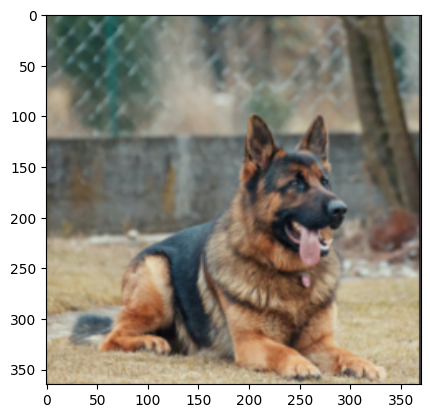

In [61]:
import matplotlib.pyplot as plt
im = plt.imread('1.png')
plt.imshow(im)

In [62]:
img = Image.open('1.png')

img_byte_arr = io.BytesIO()
img.save(img_byte_arr, format='PNG')
img_byte_arr = img_byte_arr.getvalue()

inf_payload = img_byte_arr
imagemodel_local = ImageModel_local()
res = imagemodel_local.inf_image(inf_payload)

img_class = str(res['class_index'])
with open('./imagenet_class_index.json') as labels_file:
    labels = json.load(labels_file)
print(f'Predicted image class is {labels[img_class]}')  

/mnt/cluster_storage/pypi/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/cluster_storage/pypi/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1/3] Parsed image data: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=370x365 at 0x7F2C5CD262E0>
[2/3] Images transformed, tensor shape torch.Size([1, 3, 224, 224])
[3/3] Inference done!
Predicted image class is ['n02106662', 'German_shepherd']


# Image classification example with PyTorch model

In [7]:
@serve.deployment(route_prefix="/image_predict")
class ImageModel:
    def __init__(self):
        self.model = resnet18(pretrained=True).eval()
        self.preprocessor = transforms.Compose([
           transforms.Resize(224),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           transforms.Lambda(lambda t: t[:3, ...]),  # remove alpha channel
           transforms.Normalize(
               mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    async def __call__(self, starlette_request):
        image_payload_bytes = await starlette_request.body()
        pil_image = Image.open(BytesIO(image_payload_bytes))
        print("[1/3] Parsed image data: {}".format(pil_image))

        pil_images = [pil_image]  # Our current batch size is one
        input_tensor = torch.cat(
           [self.preprocessor(i).unsqueeze(0) for i in pil_images])
        print("[2/3] Images transformed, tensor shape {}".format(
           input_tensor.shape))

        with torch.no_grad():
            output_tensor = self.model(input_tensor)
        print("[3/3] Inference done!")
        return {"class_index": int(torch.argmax(output_tensor[0]))}

In [8]:
imagemodel = ImageModel.bind()
serve.run(imagemodel)

(ServeController pid=22338) INFO 2022-12-16 10:39:21,242 controller 22338 http_state.py:129 - Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:SERVE_PROXY_ACTOR-2eca380605370e7672b163fa4c8e6e3daff3dd8cc59c19dab19fa1d6' on node '2eca380605370e7672b163fa4c8e6e3daff3dd8cc59c19dab19fa1d6' listening on '127.0.0.1:8000'
(HTTPProxyActor pid=22379) INFO:     Started server process [22379]
(ServeController pid=22338) INFO 2022-12-16 10:39:23,096 controller 22338 deployment_state.py:1310 - Adding 1 replica to deployment 'ImageModel'.
(ServeReplica:ImageModel pid=22432) Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ray/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
  0%|          | 0.00/44.7M [00:00<?, ?B/s]
 17%|█▋        | 7.80M/44.7M [00:00<00:00, 81.7MB/s]
 47%|████▋     | 20.8M/44.7M [00:00<00:00, 110MB/s] 
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


RayServeSyncHandle(deployment='ImageModel')

In [11]:
#ray.init("anyscale://workspace-cluster-kyle-sandbox", namespace="my_serve_namespace", runtime_env=runtime_env, autosuspend=-1)
# obsolete
#serve.start(detached=True)

#ImageModel.deploy()

(ServeController pid=35168) INFO 2022-12-12 18:28:17,864 controller 35168 http_state.py:129 - Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:SERVE_PROXY_ACTOR-44842751325a914ba902ee7d09b28631948f45f3ce9c61b23f516d93' on node '44842751325a914ba902ee7d09b28631948f45f3ce9c61b23f516d93' listening on '127.0.0.1:8000'
(ServeController pid=35168) INFO 2022-12-12 18:28:19,840 controller 35168 deployment_state.py:1310 - Adding 1 replica to deployment 'ImageModel'.
(HTTPProxyActor pid=35214) INFO:     Started server process [35214]


In [40]:
from anyscale import AnyscaleSDK
from PIL import Image
import io, json


sdk = AnyscaleSDK()
cluster = sdk.search_clusters(clusters_query={"name": {"equals": cluster_name}}).results[0]

img = Image.open('1.png')

img_byte_arr = io.BytesIO()
img.save(img_byte_arr, format='PNG')
img_byte_arr = img_byte_arr.getvalue()

inf_payload = img_byte_arr

resp = requests.post(
   f"{cluster.services_urls.user_service_url}/image_predict", headers={"Authorization" : f"Bearer {cluster.user_service_token}"}, data=inf_payload)
   #f"http://localhost:8000/image_predict", headers={"Authorization" : f"Bearer {cluster.user_service_token}"}, data=ray_logo_bytes)
#print(resp.json())
img_class = str(resp.json()['class_index'])
with open('./imagenet_class_index.json') as labels_file:
    labels = json.load(labels_file)
print(f'Predicted image class is {labels[img_class]}')    

(ServeReplica:ImageModel pid=22432) [1/3] Parsed image data: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=370x365 at 0x7F1AD40CEEE0>
(ServeReplica:ImageModel pid=22432) [2/3] Images transformed, tensor shape torch.Size([1, 3, 224, 224])
Predicted image class is ['n02106662', 'German_shepherd']


(HTTPProxyActor pid=22379) INFO 2022-12-16 11:34:08,496 http_proxy 10.0.1.120 http_proxy.py:361 - POST /image_predict 200 73.8ms


(ServeReplica:ImageModel pid=22432) [3/3] Inference done!


(ServeReplica:ImageModel pid=22432) INFO 2022-12-16 11:34:08,494 ImageModel ImageModel#VfhXEP replica.py:505 - HANDLE __call__ OK 69.3ms


In [41]:
serve.shutdown()

(ServeController pid=22338) INFO 2022-12-16 11:34:35,744 controller 22338 deployment_state.py:1336 - Removing 1 replica from deployment 'ImageModel'.


# Serve from CLI

In [ ]:
# Run following CLI in term
#!serve run pytorch_serve:image_model

In [42]:
import requests
ray_logo_bytes = requests.get(
    "https://raw.githubusercontent.com/ray-project/"
    "ray/master/doc/source/images/ray_header_logo.png"
).content

resp = requests.post("http://localhost:8000/", data=ray_logo_bytes)
print(resp.json())

{'class_index': 919}


# Anyscale Serve job submission

In [63]:
# Run following CLI in term
#!anyscale service deploy service.yaml

In [111]:
service_link = 'https://serve-session-52hs6b7cjyw4ts13i6cqrjqs.i.anyscaleuserdata.com'
service_token = '0eEjfbplmvS2ryLxHgkdgJcxBx5wdXG1KszjYzNGwlc'
resp = requests.post(
    f"{service_link}/image_predict", 
      headers={"Authorization" : f"Bearer {service_token}"}, 
    data=inf_payload)
print(resp)

<Response [200]>


In [112]:
img_class = str(resp.json()['class_index'])
print(f'Predicted image class is {labels[img_class]}') 

Predicted image class is ['n02106662', 'German_shepherd']
